<a href="https://colab.research.google.com/github/MAGPIEZ-CODE/MAGCalcium/blob/main/AnalisisCalciov6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**1. Import required libraries**

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.pyplot as plot
import seaborn as sns
import numpy as np
from google.colab import files
from scipy import signal
from scipy.signal import detrend
from scipy.signal import savgol_filter
from scipy.interpolate import interp1d
from scipy.signal import argrelextrema
from scipy.interpolate import CubicSpline
from scipy.signal import find_peaks

**2. Upload file**

In [ ]:
uploaded = files.upload()

Saving Results_AbPi1_1zone - With field_probenecidv3.xlsx to Results_AbPi1_1zone - With field_probenecidv3.xlsx


**3. Read the file**

In [ ]:
# Retrieve the name of the uploaded file
for filename in uploaded.keys():
    file_path = filename

# Read the Excel file
df = pd.read_excel(file_path)

# Exclude the first column (frame identifier)
df_sin_identificador = df.iloc[:, 1:]

# Identify the first empty column that separates ROIs and Background
columna_vacia = df_sin_identificador.columns[df_sin_identificador.isna().all()].tolist()

**4. Main Processing and Analysis Steps**

In [ ]:
# Initialize DataFrame to store results
df_resultado = pd.DataFrame()

# Check if an empty column exists to separate ROI and Background
if columna_vacia:
    # Step 1: Get the index of the first empty column and identify ROI and Background columns
    idx_vacio = df_sin_identificador.columns.get_loc(columna_vacia[0])
    columnas_rois = df_sin_identificador.columns[:idx_vacio]
    columnas_fondo = df_sin_identificador.columns[idx_vacio + 1:]

    # Save the original ROIs in df_resultado at the beginning
    for i, col in enumerate(columnas_rois):
        df_resultado[f'Cell({i+1})'] = df_sin_identificador[col]

    # Insert a blank column before saving background values
    df_resultado[' '] = None

    # Step 2: Calculate the average background for each frame
    avg_fondo = df_sin_identificador[columnas_fondo].mean(axis=1)
    df_resultado['Avg_Fondo'] = avg_fondo

    # Insert a blank column before saving background-subtracted ROIs
    df_resultado['  '] = None

    # Step 3: Calculate ROIs without background
    roi_sin_fondo = pd.DataFrame({
        f'ROI_sF({i+1})': df_sin_identificador[col] - avg_fondo for i, col in enumerate(columnas_rois)
    })
    df_resultado = pd.concat([df_resultado, roi_sin_fondo], axis=1)

    # Insert a blank column before adding the envelope line data
    df_resultado['   '] = None

    # Step 4: Create and smooth the lower envelope line for each ROI
    envelope_lines = pd.DataFrame()
    detrended_rois = pd.DataFrame()
    for i, col in enumerate(roi_sin_fondo.columns):
        roi_signal = roi_sin_fondo[col]

        # Find indices of local minima
        min_indices = argrelextrema(roi_signal.values, np.less)[0]
        min_values = roi_signal.iloc[min_indices]

        # Ensure there are enough points for interpolation
        if len(min_values) < 6:
            print(f"Not enough minima for ROI {i+1}. Skipping.")
            continue

        # Linear interpolation to create the envelope line based on minima
        interpolation_func = interp1d(min_indices, min_values, kind='linear', fill_value="extrapolate")
        envelope_line = interpolation_func(roi_signal.index)

        # Smooth the envelope line using forward and backward filling to replace any gaps
        envelope_line_smooth = pd.Series(envelope_line).bfill().ffill()

        envelope_lines[f'Envelope_ROI({i+1})'] = envelope_line_smooth

        # Step 5: Remove the trend using the smoothed envelope line
        detrended_signal = roi_signal - envelope_line_smooth
        detrended_rois[f'Detrended_ROI_sF({i+1})'] = detrended_signal

    # Add envelope line and detrended data to df_resultado
    df_resultado = pd.concat([df_resultado, envelope_lines], axis=1)
    df_resultado['    '] = None
    df_resultado = pd.concat([df_resultado, detrended_rois], axis=1)

    # Insert a blank column before adding ΔF/F0 without background
    df_resultado['     '] = None

    # Step 6: Calculate ΔF/F0 for each ROI without background
    df_dff0_sin_fondo = pd.DataFrame()
    for i, col in enumerate(roi_sin_fondo.columns):
        roi_signal = roi_sin_fondo[col]
        F0 = roi_signal.iloc[:6].mean()
        df_dff0_sin_fondo[f'ROI_sF_DF/F0({i+1})'] = (roi_signal - F0) / F0
    df_resultado = pd.concat([df_resultado, df_dff0_sin_fondo], axis=1)

    # Insert a blank column before ΔF/F0 detrended data
    df_resultado['      '] = None

    # Step 7: Calculate ΔF/F0 for each detrended ROI
    df_dff0_sin_tendencia = pd.DataFrame()
    for i, col in enumerate(detrended_rois.columns):
        detrended_signal = detrended_rois[col]
        F0 = detrended_signal.iloc[:6].mean()
        df_dff0_sin_tendencia[f'Detrended_ROI_sF_DF/F0({i+1})'] = (detrended_signal - F0) / F0
    df_resultado = pd.concat([df_resultado, df_dff0_sin_tendencia], axis=1)

    # Insert a blank column before activity calculations
    df_resultado['       '] = None

    # Step 8: Calculate activity from ΔF/F0 without envelope trend
    activity_df = pd.DataFrame()
    for i, col in enumerate(df_dff0_sin_tendencia.columns):
        detrended_dff0_signal = df_dff0_sin_tendencia[col]
        std_f0 = detrended_dff0_signal.iloc[:6].std()
        activity_threshold = 3 * std_f0  # Threshold of 3 times the standard deviation
        prominence_threshold = 0.05  # Prominence threshold of 5%

        # Find peaks that meet the prominence condition
        peaks, properties = find_peaks(detrended_dff0_signal, prominence=(prominence_threshold, None))

        # Check which peaks also exceed the 3 standard deviation threshold
        peak_activity = np.zeros(len(detrended_dff0_signal), dtype=int)
        peak_activity[peaks] = (detrended_dff0_signal.iloc[peaks] > activity_threshold).astype(int)

        # Save the activity for the ROI in the DataFrame
        activity_df[f'Activity_Detrended_ROI({i+1})'] = peak_activity

    df_resultado = pd.concat([df_resultado, activity_df], axis=1)

    # Insert a blank column before activity calculations from ROIs only without background
    df_resultado['        '] = None  # Blank column between activity steps

    # Step 9: Activity based on ΔF/F0 in ROIs only without background
    activity_sin_fondo = pd.DataFrame()
    activity_summary = {}  # Dictionary to store summary statistics for each ROI

    for i, col in enumerate(df_dff0_sin_fondo.columns):
        dff0_signal = df_dff0_sin_fondo[col]
        std_f0 = dff0_signal.iloc[:6].std()
        activity_threshold = 3 * std_f0
        selected_dff0_values = []  # Store DF/F0 values that meet the activity criteria for this ROI
        prominence_threshold = 0.05  # Prominence threshold of 5%

        # Find peaks that meet the prominence condition
        peaks, properties = find_peaks(dff0_signal, prominence=(prominence_threshold, None))

        # Initialize an array to store either the DF/F0 value (if it meets the threshold) or 0
        peak_activity = np.zeros(len(dff0_signal))

        # Store the DF/F0 values for peaks that meet the 3 standard deviation threshold
        for peak in peaks:
            if dff0_signal.iloc[peak] > activity_threshold:
                peak_activity[peak] = dff0_signal.iloc[peak]
                selected_dff0_values.append(dff0_signal.iloc[peak])

        # Save the activity for the ROI in the DataFrame (0 if no activity, value of DF/F0 if there is activity)
        activity_sin_fondo[f'Activity_ROI_sF({i+1})'] = peak_activity

        # Calculate summary statistics for the current ROI
        if selected_dff0_values:
            mean_selected_dff0 = np.mean(selected_dff0_values)
            std_selected_dff0 = np.std(selected_dff0_values)
            count_selected_dff0 = len(selected_dff0_values)
        else:
            mean_selected_dff0 = 0
            std_selected_dff0 = 0
            count_selected_dff0 = 0

        # Print the statistics for the current ROI
        print(f"ROI {i+1} - Count of frames with activity: {count_selected_dff0}")
        print(f"ROI {i+1} - Mean of DF/F0 for activity: {mean_selected_dff0}")
        print(f"ROI {i+1} - Standard deviation of DF/F0 for activity: {std_selected_dff0}")

        # Store the statistics in the summary dictionary
        activity_summary[f'Mean_Activity_DF/F0_ROI({i+1})'] = mean_selected_dff0
        activity_summary[f'STD_Activity_DF/F0_ROI({i+1})'] = std_selected_dff0
        activity_summary[f'Count_Activity_Frames_ROI({i+1})'] = count_selected_dff0

    # Add the activity data to df_resultado
    df_resultado = pd.concat([df_resultado, activity_sin_fondo], axis=1)

    # Insertar un bloque de cálculo de ΔF/F0 usando la envolvente inferior como paso 10
    df_resultado['         '] = None  # Columna en blanco antes de los nuevos cálculos

    # Add summary statistics to df_resultado as a new row
    df_resultado = pd.concat([df_resultado, pd.DataFrame([activity_summary])], ignore_index=True)

    # Insertar un bloque de cálculo de ΔF/F0 usando la envolvente inferior como paso 10
    df_resultado['         '] = None  # Columna en blanco antes de los nuevos cálculos

    # Paso 10: Calcular ΔF/F0 para cada envolvente inferior, usando el promedio de los primeros 6 valores de la envolvente como F0
    df_dff0_envelope = pd.DataFrame()
    for i, col in enumerate(envelope_lines.columns):
        envelope_signal = envelope_lines[col]
        F0 = envelope_signal.iloc[:6].mean()  # F0 basado en los primeros 6 valores de la envolvente
        df_dff0_envelope[f'Envelope_DF/F0({i+1})'] = (envelope_signal - F0) / F0  # Cálculo de ΔF/F0
    df_resultado = pd.concat([df_resultado, df_dff0_envelope], axis=1)

    # Insertar una columna en blanco antes del cálculo de área bajo la curva de ΔF/F0 de la envolvente
    df_resultado['          '] = None

    # Paso 11: Calcular el área bajo la curva de ΔF/F0 para la envolvente inferior desde el fotograma 6 hasta el final
    area_dff0_envelope = {}
    for i, col in enumerate(df_dff0_envelope.columns):
        dff0_signal = df_dff0_envelope[col].iloc[5:]  # Desde el fotograma 6
        area_dff0 = np.trapz(dff0_signal, dx=1)  # Integración numérica con regla del trapecio
        area_dff0_envelope[f'Area_DF/F0_Envelope({i+1})'] = area_dff0
    df_resultado = pd.concat([df_resultado, pd.DataFrame([area_dff0_envelope])], ignore_index=True)

    # Insertar una columna en blanco antes del cálculo de área bajo la curva de ΔF/F0 de la envolvente
    df_resultado['          '] = None

    # Paso 12: Crear la gráfica de violín de los valores de área calculados y mostrar el promedio como un punto rojo

    # Crear la lista de áreas para el gráfico de violín
    auc_values = list(area_dff0_envelope.values())

    # Save results to an Excel file
    df_resultado.to_excel("output_calculated_steps_with_smoothed_envelope_detrended_area.xlsx", index=False)

    print("All calculations completed and saved to 'output_calculated_steps_with_smoothed_envelope_detrended_area.xlsx'.")

else:
    print("No empty column found to separate ROIs and background.")


ROI 1 - Count of frames with activity: 3
ROI 1 - Mean of DF/F0 for activity: 0.3341727519289342
ROI 1 - Standard deviation of DF/F0 for activity: 0.14107785473773032
ROI 2 - Count of frames with activity: 0
ROI 2 - Mean of DF/F0 for activity: 0
ROI 2 - Standard deviation of DF/F0 for activity: 0
ROI 3 - Count of frames with activity: 4
ROI 3 - Mean of DF/F0 for activity: 0.25817834575575227
ROI 3 - Standard deviation of DF/F0 for activity: 0.0919697676533505
ROI 4 - Count of frames with activity: 0
ROI 4 - Mean of DF/F0 for activity: 0
ROI 4 - Standard deviation of DF/F0 for activity: 0
ROI 5 - Count of frames with activity: 0
ROI 5 - Mean of DF/F0 for activity: 0
ROI 5 - Standard deviation of DF/F0 for activity: 0
ROI 6 - Count of frames with activity: 1
ROI 6 - Mean of DF/F0 for activity: 0.2393944324741949
ROI 6 - Standard deviation of DF/F0 for activity: 0.0
ROI 7 - Count of frames with activity: 0
ROI 7 - Mean of DF/F0 for activity: 0
ROI 7 - Standard deviation of DF/F0 for activi

**5. Plot the original ROI data without any processing**

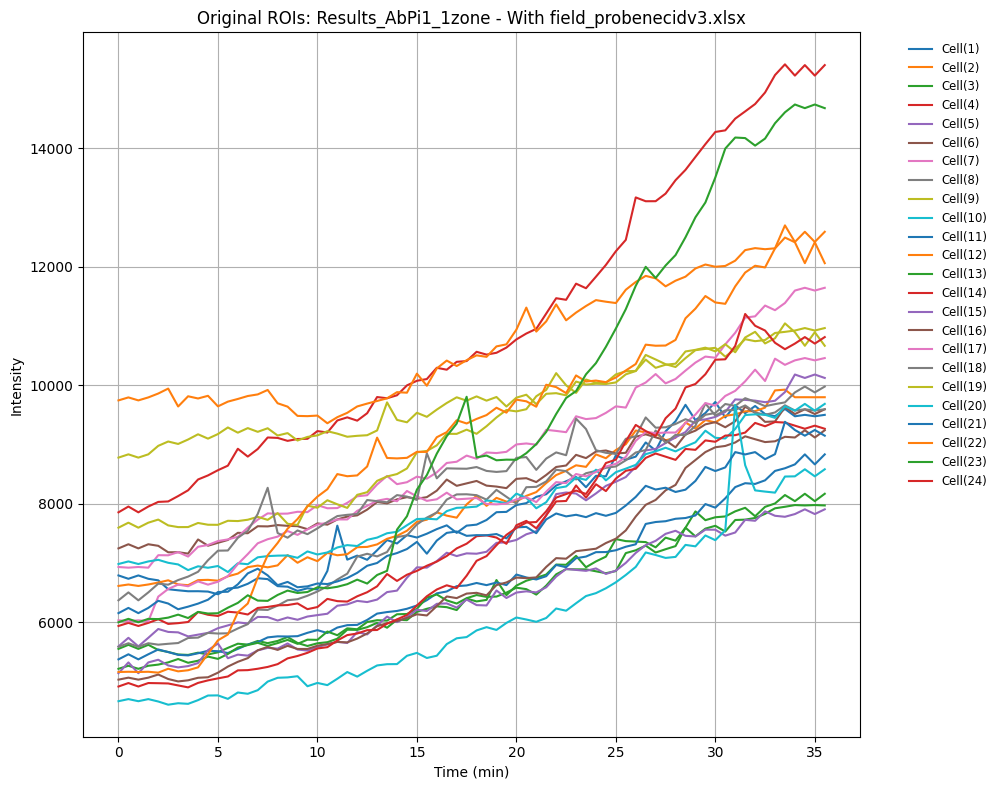

In [ ]:
plt.figure(figsize=(12, 8))

# Plot each original ROI signal
for i, col in enumerate([col for col in df_resultado.columns if col.startswith("Cell(")]):
    plt.plot(df_resultado.index * 0.5, df_resultado[col], label=col)

plt.title(f"Original ROIs: {filename}")
plt.xlabel("Time (min)")
plt.ylabel("Intensity")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small', frameon=False)
plt.grid(True)
plt.tight_layout(rect=[0, 0, 0.85, 1])

plt.show()

**6. Plot the ROI data with background subtracted**

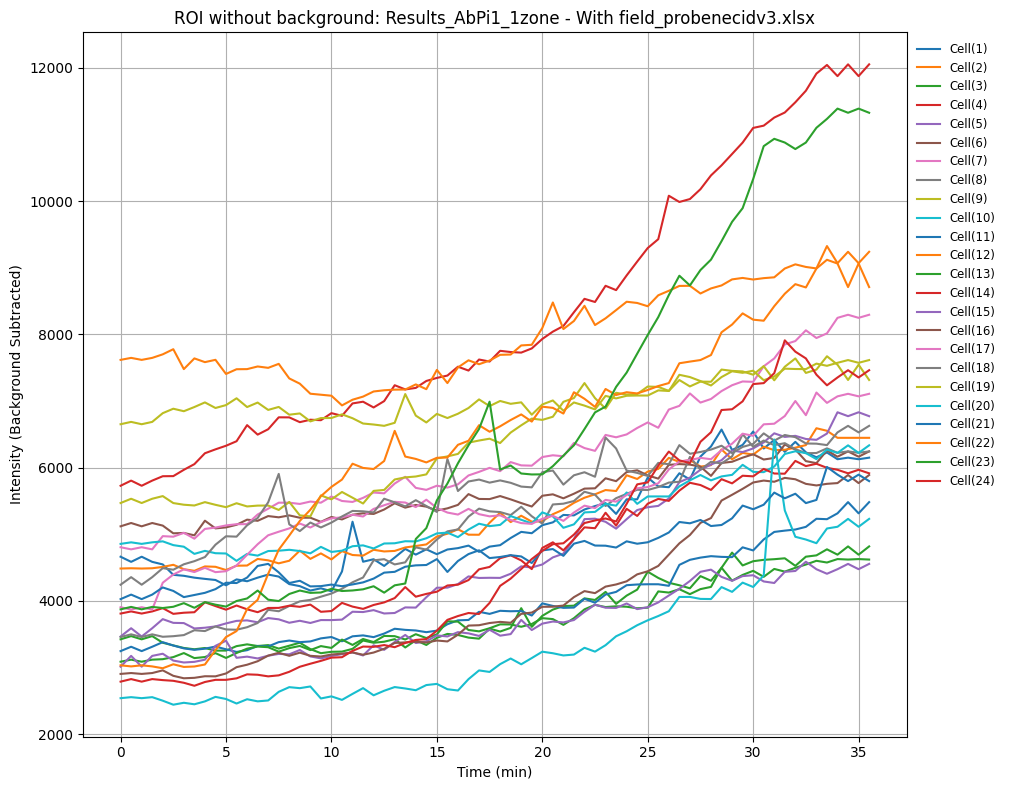

In [ ]:
# Plot the ROI data with background subtracted
plt.figure(figsize=(12, 8))

for i in range(len(columnas_rois)):
    plt.plot(df_resultado.index*0.5, df_resultado[f'ROI_sF({i+1})'], label=f'Cell({i+1})')

plt.legend(bbox_to_anchor=(1, 1), loc='upper left', fontsize='small', frameon=False)
plt.title(f"ROI without background: {filename}")
plt.xlabel("Time (min)")
plt.ylabel("Intensity (Background Subtracted)")
plt.grid(True)
plt.tight_layout(rect=[0, 0, 0.85, 1])
plt.show()

**7. Plot of ΔF/F0 of Original ROI without background**

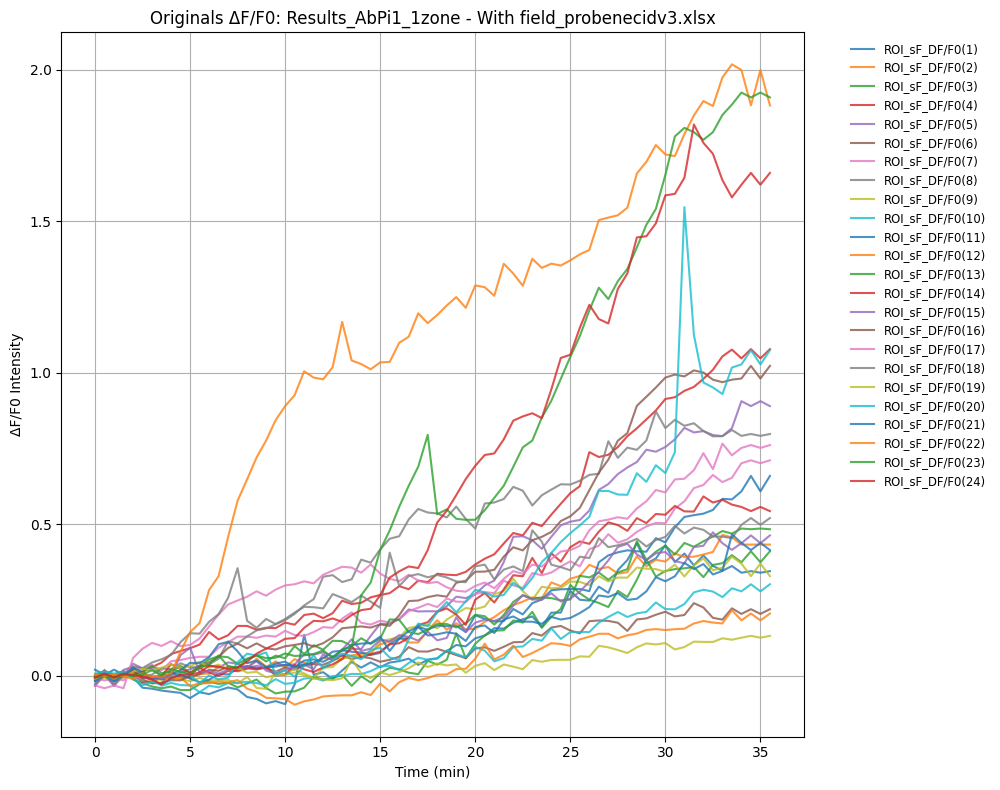

In [ ]:
# Create a figure for plotting ΔF/F0 for each ROI
plt.figure(figsize=(12, 8))

for col in df_resultado.columns:
    if "ROI_sF_DF/F0" in col and "Detrended" not in col:
        plt.plot(df_resultado.index*0.5, df_resultado[col], label=col, alpha=0.8)

plt.title(f"Originals ΔF/F0: {filename}")
plt.xlabel("Time (min)")
plt.ylabel("ΔF/F0 Intensity")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small', frameon=False)
plt.grid(True)
plt.tight_layout(rect=[0, 0, 0.85, 1])

plt.show()

**8. Heatmap of DF/F0 of Original ROI without background**

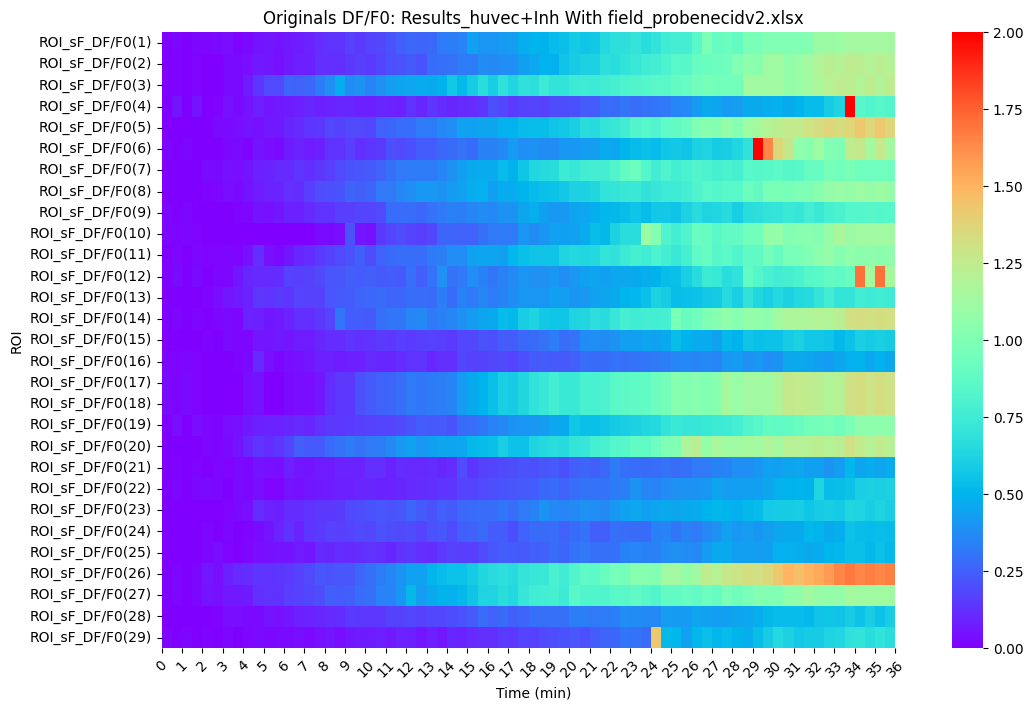

In [ ]:
# Create a heatmap for plotting ΔF/F0 for each ROI
roi_sf_dff0_data = df_resultado[[col for col in df_resultado.columns if "ROI_sF_DF/F0" in col and "Detrended" not in col]]

plt.figure(figsize=(12, 8))
sns.heatmap(roi_sf_dff0_data.T, cmap="rainbow", cbar=True, annot=False, vmin=0, vmax=2)

plt.title(f"Originals DF/F0: {filename}")
plt.xlabel("Time (min)")
plt.ylabel("ROI")

num_frames = roi_sf_dff0_data.shape[0]
time_labels = np.arange(0, num_frames * 0.5, 0.5)
integer_time_labels = [int(time) for time in time_labels if time.is_integer()]

plt.xticks(ticks=np.arange(0, num_frames, 2), labels=integer_time_labels, rotation=45)

plt.show()

**9. Heatmap of Activity of Original ROI without background with find peak**

NameError: name 'roi_sf_dff0_data' is not defined

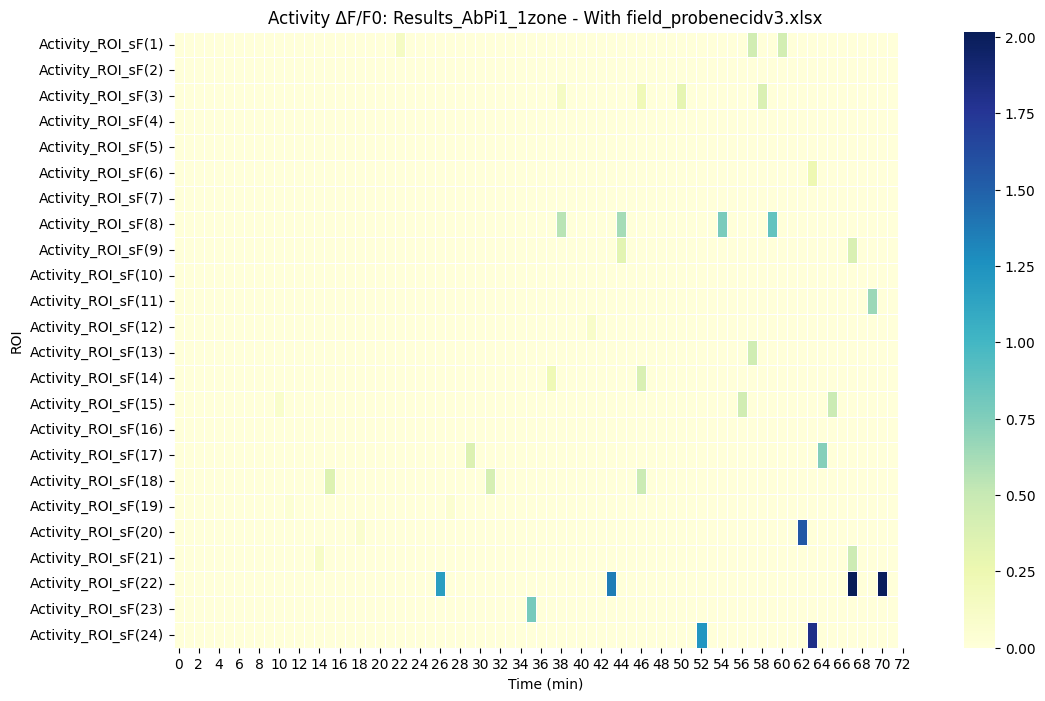

In [ ]:
# Create a heatmap for plotting Activity for each ROI with find peak
activity_roi_sf_data = df_resultado[[col for col in df_resultado.columns if "Activity_ROI_sF" in col]]

plt.figure(figsize=(12, 8))
sns.heatmap(activity_roi_sf_data.T, cmap="YlGnBu", cbar=True, annot=False, linewidths=.5)

plt.title(f"Activity ΔF/F0: {filename}")
plt.xlabel("Time (min)")
plt.ylabel("ROI")

num_frames = roi_sf_dff0_data.shape[0]
time_labels = np.arange(0, num_frames * 0.5, 0.5)
integer_time_labels = [int(time) for time in time_labels if time.is_integer()]

plt.xticks(ticks=np.arange(0, num_frames, 2), labels=integer_time_labels, rotation=45)

plt.show()

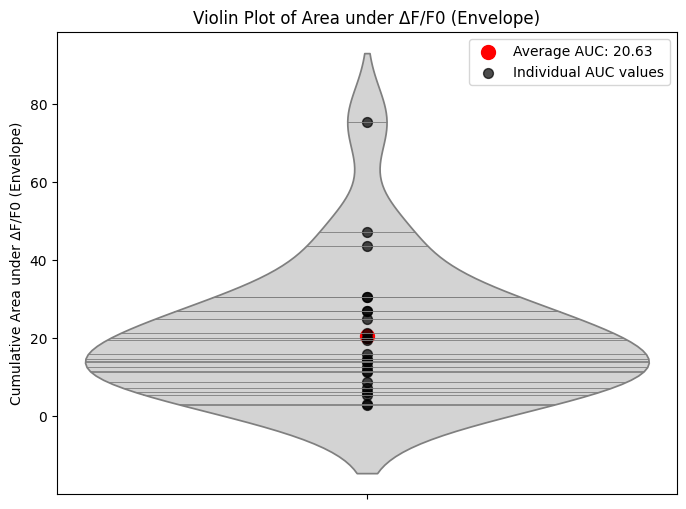

In [ ]:
# Paso 12: Crear la gráfica de violín de los valores de área calculados y mostrar el promedio como un punto rojo
plt.figure(figsize=(8, 6))
sns.violinplot(data=auc_values, inner="stick", color="lightgray")  # Gráfico de violín sin puntos internos

# Añadir el promedio de AUC como un punto rojo
mean_auc = np.mean(auc_values)
plt.scatter(0, mean_auc, color="red", s=100, label=f'Average AUC: {mean_auc:.2f}')  # Etiqueta del promedio

# Añadir los valores individuales de AUC como puntos negros
plt.scatter([0] * len(auc_values), auc_values, color="black", s=50, alpha=0.7, label="Individual AUC values")

# Ajustes de la gráfica
plt.ylabel("Cumulative Area under ΔF/F0 (Envelope)")
plt.title("Violin Plot of Area under ΔF/F0 (Envelope)")
plt.legend()
plt.show()

**16. Save the generated file**

In [ ]:
# Guardar el archivo modificado en Excel
df_resultado.to_excel('archivo_procesado.xlsx', index=False)
print("El archivo modificado ha sido guardado como 'archivo_procesado.xlsx'")

El archivo modificado ha sido guardado como 'archivo_procesado.xlsx'


In [ ]:
# Descargar el archivo en tu computadora
files.download('archivo_procesado.xlsx')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>